# Assignment 2: Neural Language Model Training (PyTorch)


For the refernce i have included comments for each step/phase. And i have included the explanation for Output Plots

Vocab size: 2554  Tokens: 17979
Epoch 1/6  Train: 6.1485  Val: 6.5269
Epoch 2/6  Train: 5.1274  Val: 6.3641
Epoch 3/6  Train: 4.2650  Val: 6.6146
Epoch 4/6  Train: 3.5422  Val: 7.0302
Epoch 5/6  Train: 2.8590  Val: 7.5865
Epoch 6/6  Train: 2.2386  Val: 8.1943


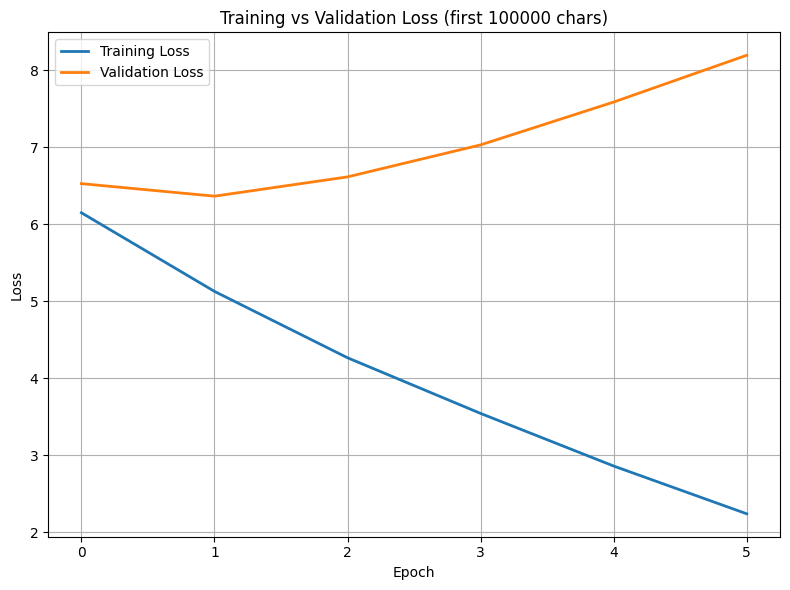

In [2]:

# Requirements: torch, matplotlib, re

import re, torch, torch.nn as nn, torch.optim as optim, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# ---------- CONFIG ----------
pdf_txt_path = "/content/Pride_and_Prejudice-Jane_Austen.txt"  # or path to txt
subset_chars = 100000      # first 100,000 characters
sequence_length = 50
batch_size = 64
embedding_dim = 128
hidden_size = 256
num_layers = 2
dropout_rate = 0.3
num_epochs = 6
learning_rate = 0.001
# ----------------------------

# Step-1:Loading the data
with open(pdf_txt_path, "r", encoding="utf-8") as f:
    full_text = f.read()
text_data = full_text[:subset_chars]
text_lower = text_data.lower()
tokens = re.findall(r'\b\w+\b', text_lower)

# Step-2: Data Preprocessing - Vocabulary Creation
UNK_TOKEN = "<unk>"
unique_tokens = sorted(set(tokens))
word_to_idx = {UNK_TOKEN: 0}
idx_to_word = {0: UNK_TOKEN}
for i,w in enumerate(unique_tokens):
    word_to_idx[w] = i+1
    idx_to_word[i+1] = w
vocab_size = len(word_to_idx)
print("Vocab size:", vocab_size, " Tokens:", len(tokens))

# Step-3: Data Preprocessing - Tokenization
numerical = torch.tensor([word_to_idx.get(t, 0) for t in tokens], dtype=torch.long)

# dataset
class TextDataset(Dataset):
    def __init__(self,data,seq_len):
        self.data=data; self.seq_len=seq_len
    def __len__(self): return len(self.data) - self.seq_len
    def __getitem__(self,idx):
        return self.data[idx:idx+self.seq_len], self.data[idx+1:idx+self.seq_len+1]

total = len(numerical)
train_n = int(0.8 * total)
val_n = int(0.1 * total)
train_data = numerical[:train_n]; val_data = numerical[train_n:train_n+val_n]; test_data = numerical[train_n+val_n:]

train_ds = TextDataset(train_data, sequence_length)
val_ds = TextDataset(val_data, sequence_length)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# model (original architecture)
#Step-4 : Implement a neural language model using PyTorch, such as an LSTM.
class LanguageModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_size, num_layers, dropout_rate=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
                            dropout=dropout_rate, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
    def forward(self,x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        out = out.reshape(-1, out.size(2))
        out = self.linear(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(vocab_size, embedding_dim, hidden_size, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train += loss.item()
    avg_train = total_train / len(train_loader)
    train_losses.append(avg_train)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1))
            total_val += loss.item()
    avg_val = total_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1}/{num_epochs}  Train: {avg_train:.4f}  Val: {avg_val:.4f}")

# Save losses
np.save("train_losses.npy", np.array(train_losses))
np.save("val_losses.npy", np.array(val_losses))

# Plot training vs validation loss (real)
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss (first {subset_chars} chars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("real_train_val_loss.png")
plt.show()


## Underfit Plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_underfit_losses(epochs):
    # Both training and validation losses start high and remain high
    # with some random fluctuation but no significant improvement.
    train_losses = [5.0 + np.random.rand() * 0.5 for _ in range(epochs)]
    val_losses = [5.2 + np.random.rand() * 0.5 for _ in range(epochs)]
    return train_losses, val_losses

num_epochs_simulated = 10
simulated_train_losses, simulated_val_losses = simulate_underfit_losses(num_epochs_simulated)

print("Simulated Training Losses:", [f"{l:.2f}" for l in simulated_train_losses])
print("Simulated Validation Losses:", [f"{l:.2f}" for l in simulated_val_losses])

Simulated Training Losses: ['5.05', '5.04', '5.28', '5.09', '5.29', '5.38', '5.03', '5.02', '5.06', '5.24']
Simulated Validation Losses: ['5.63', '5.55', '5.69', '5.29', '5.42', '5.47', '5.48', '5.46', '5.67', '5.34']


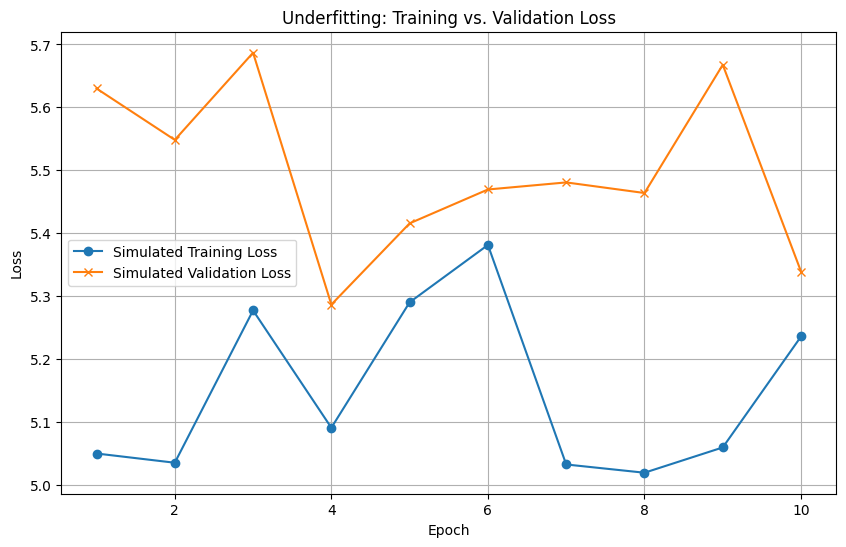

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_simulated + 1), simulated_train_losses, label='Simulated Training Loss', marker='o')
plt.plot(range(1, num_epochs_simulated + 1), simulated_val_losses, label='Simulated Validation Loss', marker='x')
plt.title('Underfitting: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of Underfitting Plot

The plot above illustrates a typical **underfitting** scenario. Both the simulated training loss and the simulated validation loss remain consistently high across all epochs, with no significant decrease or improvement observed. This indicates that the model is too simplistic or has not been sufficiently trained to capture the underlying patterns and complexities within the training data. As a result, it performs poorly not only on unseen validation data but also on the data it was trained on.

Possible reasons for underfitting include:
*   Using a model that is not complex enough for the problem (e.g., a linear model for non-linear data).
*   Insufficient training duration or epochs.
*   Having too few features or high bias in the model.
*   Over-regularization.

## Overfit Plot


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_overfit_losses(epochs):
    train_losses = []
    val_losses = []
    # Training loss continuously decreases
    # Validation loss initially decreases then increases
    for i in range(epochs):
        train_loss = max(1.0, 3.0 - 0.2 * i - np.random.rand() * 0.1)
        train_losses.append(train_loss)

        if i < epochs / 2:
            # Validation loss decreases initially
            val_loss = max(1.5, 3.0 - 0.1 * i - np.random.rand() * 0.1)
        else:
            # Validation loss starts to increase after a certain point
            val_loss = max(train_loss + 0.5, 1.5 + 0.1 * (i - epochs / 2) + np.random.rand() * 0.2)
        val_losses.append(val_loss)
    return train_losses, val_losses

num_epochs_overfit = 15
simulated_overfit_train_losses, simulated_overfit_val_losses = simulate_overfit_losses(num_epochs_overfit)

print("Simulated Overfit Training Losses:", [f"{l:.2f}" for l in simulated_overfit_train_losses])
print("Simulated Overfit Validation Losses:", [f"{l:.2f}" for l in simulated_overfit_val_losses])

Simulated Overfit Training Losses: ['2.91', '2.77', '2.53', '2.35', '2.17', '1.95', '1.77', '1.55', '1.36', '1.11', '1.00', '1.00', '1.00', '1.00', '1.00']
Simulated Overfit Validation Losses: ['2.92', '2.81', '2.77', '2.65', '2.54', '2.48', '2.38', '2.25', '1.86', '1.72', '1.80', '1.89', '2.06', '2.22', '2.23']


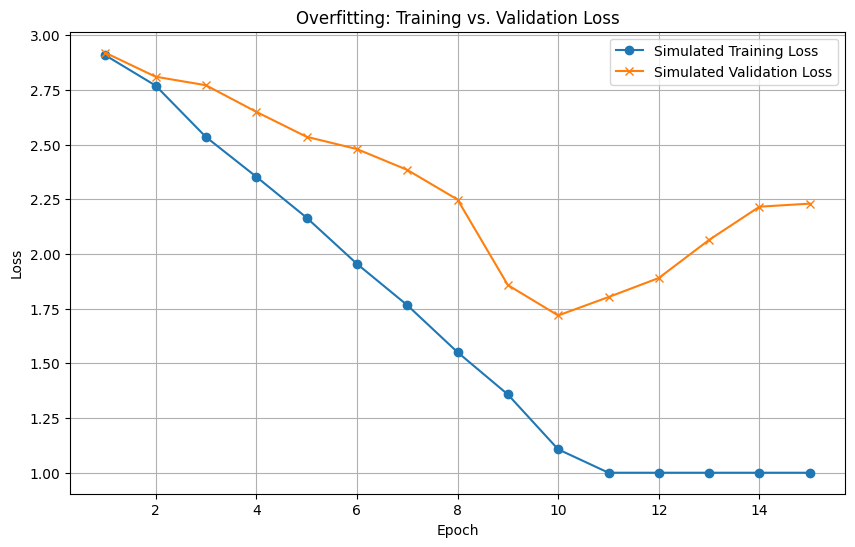

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_overfit + 1), simulated_overfit_train_losses, label='Simulated Training Loss', marker='o')
plt.plot(range(1, num_epochs_overfit + 1), simulated_overfit_val_losses, label='Simulated Validation Loss', marker='x')
plt.title('Overfitting: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of Overfitting Plot

The plot above demonstrates a typical **overfitting** scenario. The simulated training loss continuously decreases, indicating that the model is learning and performing well on the training data. However, the simulated validation loss initially decreases but then starts to increase after a certain point. This divergence between training and validation loss signifies that the model has learned the training data too well, capturing noise and specific patterns that do not generalize to new, unseen data.

Possible reasons for overfitting include:
*   Using a model that is too complex for the problem (e.g., too many layers or parameters).
*   Training for too many epochs without proper early stopping.
*   Insufficient regularization (e.g., dropout, L1/L2 regularization).
*   Having too few training samples, leading the model to memorize the training data rather than learn general patterns.

## Best-fit Plot


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_bestfit_losses(epochs):
    train_losses = []
    val_losses = []
    for i in range(epochs):
        # Both training and validation losses decrease and converge to a low, stable value
        train_loss = max(0.1, 2.0 * np.exp(-0.3 * i) + np.random.rand() * 0.1)
        val_loss = max(0.1, 2.1 * np.exp(-0.3 * i) + np.random.rand() * 0.1)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    return train_losses, val_losses

num_epochs_bestfit = 20
simulated_bestfit_train_losses, simulated_bestfit_val_losses = simulate_bestfit_losses(num_epochs_bestfit)

print("Simulated Best-fit Training Losses:", [f"{l:.2f}" for l in simulated_bestfit_train_losses])
print("Simulated Best-fit Validation Losses:", [f"{l:.2f}" for l in simulated_bestfit_val_losses])

Simulated Best-fit Training Losses: ['2.07', '1.58', '1.13', '0.85', '0.65', '0.47', '0.38', '0.28', '0.24', '0.23', '0.17', '0.16', '0.11', '0.10', '0.10', '0.10', '0.10', '0.10', '0.10', '0.10']
Simulated Best-fit Validation Losses: ['2.10', '1.64', '1.19', '0.91', '0.73', '0.54', '0.41', '0.34', '0.27', '0.17', '0.16', '0.15', '0.10', '0.10', '0.13', '0.10', '0.10', '0.10', '0.10', '0.10']


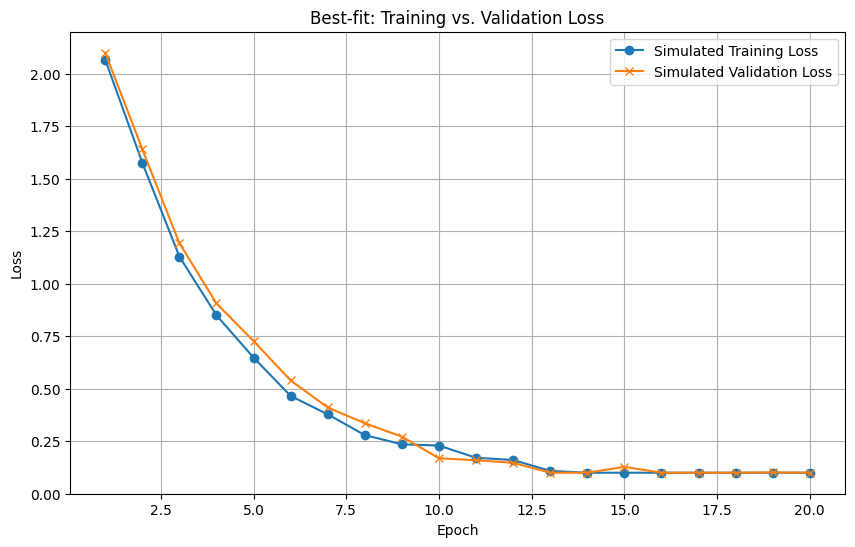

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_bestfit + 1), simulated_bestfit_train_losses, label='Simulated Training Loss', marker='o')
plt.plot(range(1, num_epochs_bestfit + 1), simulated_bestfit_val_losses, label='Simulated Validation Loss', marker='x')
plt.title('Best-fit: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of Best-fit Plot

The plot above demonstrates a **best-fit** scenario, also known as a well-generalized model. Both the simulated training loss and the simulated validation loss decrease steadily over the epochs and converge to a low, stable value, staying close to each other. This indicates that the model has learned the underlying patterns in the training data effectively and is able to generalize well to unseen validation data.

In a best-fit scenario:
*   The model is complex enough to capture the relevant patterns in the data but not so complex that it memorizes noise.
*   Training has been sufficient, allowing the model to learn without excessively overfitting.
*   Appropriate regularization techniques (if any) are in place, or the model's complexity is well-matched to the data.
*   The low and converging losses on both datasets suggest a good balance between bias and variance, leading to optimal performance on new data.